# Car theft is much more common in Seattle than in San Francisco, while the difference is less pronounced for thefts from cars
Author: Albert Wildeman

This notebook compares the frequency of car thefts and thefts from cars in Seattle in San Francisco over the summer of 2014. After loading the necessary libraries and initializing the graphical environment,

In [49]:
# import the necessary libraries and set up matplotlib graphics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12.0, 8.0)
plt.style.use('ggplot')

the raw data from each city is loaded and used to compile the occurrences of each type of theft for each city, both as a count per month per 100,000 population and as a percentage of total police reports:

In [3]:
# Load the raw data
df_Se = pd.read_csv('data\seattle_incidents_summer_2014.csv', low_memory=False)
df_SF = pd.read_csv('data\sanfrancisco_incidents_summer_2014.csv', low_memory=False)

# Get total number of reports of stolen cars and thefts from cars, for each city
# Source for Seattle police offense codes: data.seattle.gov/Public-Safety/SPD-Offense-Codes/22zb-azac/data
# It is assumed here that events filed as either grand theft and petty theft, and from either a locked car or an unlocked car 
# in SF are filed as carprowls in Seattle.
Se = pd.Series( data=[ (df_Se['Offense Code']=='2404').sum(),
                       (df_Se['Offense Code']=='2305').sum()], index=['cartheft', 'carprowl'])
SF = pd.Series( data=[ (df_SF['Descript']=='STOLEN AUTOMOBILE').sum(),
                      ((df_SF['Descript']=='GRAND THEFT FROM LOCKED AUTO') | 
                       (df_SF['Descript']=='PETTY THEFT FROM LOCKED AUTO') | 
                       (df_SF['Descript']=='PETTY THEFT FROM UNLOCKED AUTO')).sum()], index=['cartheft', 'carprowl'])

# Population for each city as of the 2010 census:
pop_Se = 608660
pop_SF = 820445
# Rates of each type of theft per month in each city, per 100000 inhibitants. Divide by 3 because the counts are for 3 months.
per_pop = pd.concat([Se*100000/(pop_Se*3),SF*100000/(pop_SF*3)], axis=1)
per_pop.columns = ['Se', 'SF']

# Total police reports for each city
total_Se = df_Se.shape[0]
total_SF = df_SF.shape[0]
# The number of thefts of each type, as % of total police reports (per city)
per_ttl = pd.concat([100*Se/total_Se,100*SF/total_Se], axis=1)
per_ttl.columns = ['Se', 'SF']

With the data prepared, the graphs can be generated:

In [148]:
Se_cartheft_byday = df_Se.loc[ df_Se['Offense Code']=='2404', 'Date Reported'].apply(lambda x : x[:10]).value_counts().values
Se_carprowl_byday = df_Se.loc[ df_Se['Offense Code']=='2305', 'Date Reported'].apply(lambda x : x[:10]).value_counts().values

SF_cartheft_byday = df_SF.loc[ df_SF['Descript']=='STOLEN AUTOMOBILE', 'Date'].value_counts().values
SF_carprowl_byday = df_SF.loc[(df_SF['Descript']=='GRAND THEFT FROM LOCKED AUTO') | 
                              (df_SF['Descript']=='PETTY THEFT FROM LOCKED AUTO') | 
                              (df_SF['Descript']=='PETTY THEFT FROM UNLOCKED AUTO'), 'Date'].value_counts().values

# try a df instead
daily_counts = pd.DataFrame(data = [[Se_cartheft_byday, SF_cartheft_byday], [Se_carprowl_byday, SF_carprowl_byday]], 
                            columns = ['Seattle', 'San Francisco'], index=['car thefts','thefts from cars'])
daily_counts

,Seattle,San Francisco
car thefts,"[56, 56, 56, 55, 55, 55, 51, 50, 49, 48, 46, 4...","[30, 28, 25, 24, 24, 23, 22, 19, 19, 19, 19, 1..."
thefts from cars,"[118, 102, 96, 95, 89, 88, 85, 84, 83, 83, 81,...","[88, 87, 86, 82, 79, 77, 76, 74, 71, 70, 69, 6..."


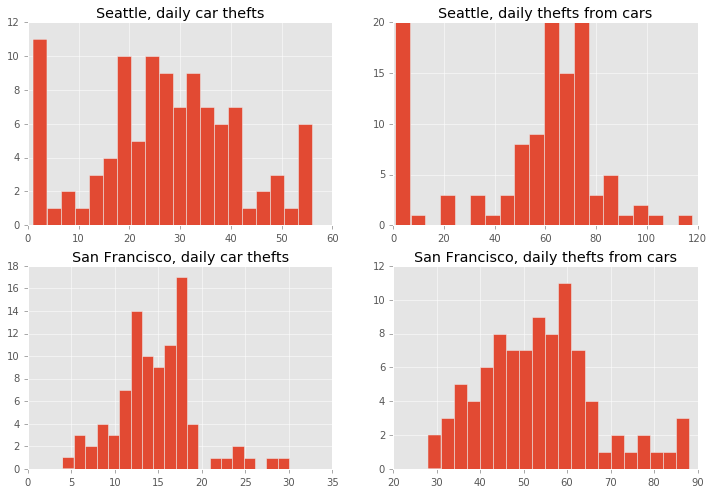

In [157]:
cities = ["Seattle", "San Francisco"]
crimes = ["car thefts", "thefts from cars"]

f, axarr = plt.subplots(2, 2)

for icity in [0,1]:
    for icrime in [0,1]:
        axarr[icity, icrime].hist(daily_counts.loc[crimes[icrime], cities[icity]], bins=20)
        axarr[icity, icrime].set_title(cities[icity] + ", daily " + crimes[icrime])
        axarr[icity, icrime].xaxis.tick_bottom()
        axarr[icity, icrime].yaxis.tick_left()
        

These are certainly not all normal, so use bootstrapping rather than normal approximation to get confidence interval.

In [110]:


def bootstrap_sum(data, num_samples, alpha):
    """Returns bootstrap estimate of 100.0*(1-alpha) CI for statistic."""
    n = len(data)
    idx = np.random.randint(0, n, (num_samples, n))
    samples = data[idx]
    #stat = np.sort(statistic(samples, 0))
    stat = np.sort(samples.sum(axis=1), 0)
    return (stat[int((alpha/2.0)*num_samples)],
            stat[int((1-alpha/2.0)*num_samples)])

n_samples = 10000
alpha = 0.05
Se_cartheft_CI = bootstrap_sum(Se_cartheft_byday, n_samples, alpha)
SF_cartheft_CI = bootstrap_sum(SF_cartheft_byday, n_samples, alpha)
Se_carprowl_CI = bootstrap_sum(Se_carprowl_byday, n_samples, alpha)
SF_carprowl_CI = bootstrap_sum(SF_carprowl_byday, n_samples, alpha)

print(Se_theft_CI)

(2589, 3154)


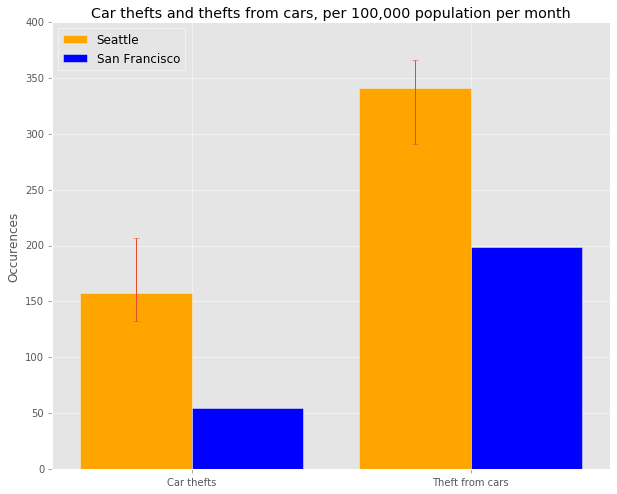

In [5]:
# open up a figure
fig, ax = plt.subplots()
ind = np.arange(2)  # the x locations for the groups
width = 0.4     # the width of the bars

# Create bar graphs for the thefts of each type, per city, in count per month per 100,000 population:
bars_pop_Se = ax.bar(ind+0.1, per_pop.Se.values, width, color='orange', yerr=[[25,50],[50,25]])
bars_pop_SF = ax.bar(ind+0.1+width, per_pop.SF.values, width, color='b')

# add some text for labels, title and axes ticks
ax.set_title('Car thefts and thefts from cars, per 100,000 population per month')
ax.set_ylabel('Occurences')
ax.set_xticks(ind + 0.1 + width); ax.set_xticklabels(('Car thefts', 'Theft from cars'))
ax.xaxis.tick_bottom(); ax.yaxis.tick_left()
ax.set_ylim(0,400)
# add legend
ax.legend((bars_pop_Se[0], bars_pop_SF[0]), ('Seattle', 'San Francisco'), loc='upper left');

This graph shows that thefts from cars are more common than car thefts in both cities, which is unsurprising given the risks involved with each type of theft. More interestingly, both are much more common in Seattle than in San Francisco, with the difference being more pronounced for car thefts.
To investigate whether the differences between the cities are specific to these types of thefts or simply reflect generally different crime levels, a graph is generated to display the percentage of police reports in either city that is due to these types of thefts:

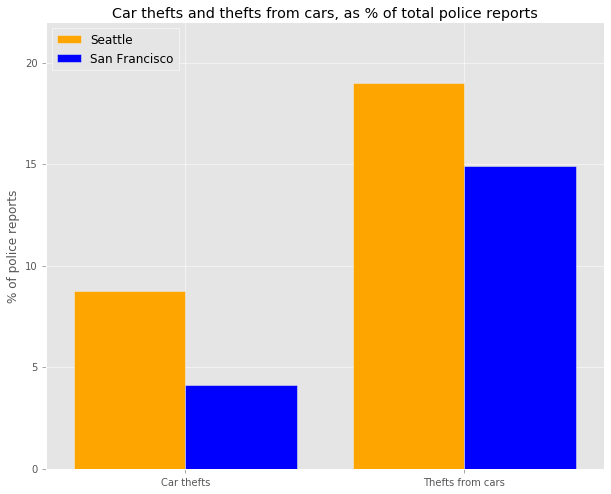

In [4]:
# open up a figure
fig, ax = plt.subplots()

# Create bar graphs for the thefts of each type, per city, as % of total police reports (per city)
bars_ttl_Se = ax.bar(ind+0.1, per_ttl.Se.values, width, color='orange')
bars_ttl_SF = ax.bar(ind+0.1+width, per_ttl.SF.values, width, color='b')

# add some text for labels, title and axes ticks
ax.set_title('Car thefts and thefts from cars, as % of total police reports')
ax.set_ylabel('% of police reports')
ax.set_xticks(ind + 0.1 + width); ax.set_xticklabels(('Car thefts', 'Thefts from cars'))
ax.xaxis.tick_bottom(); ax.yaxis.tick_left()
ax.set_xlim(0,2); ax.set_ylim(0,22)
# add legend
ax.legend((bars_ttl_Se[1], bars_ttl_SF[1]), ('Seattle', 'San Francisco'), loc='upper left');

This graph reveals that when general crime levels are taken into account the number of thefts from cars aren't dramatically different between the two cities, whereas the number of car thefts in Seattle is still about double the number in San Francisco.